# STADVDB MCO1: Query Processing in a Data Warehouse
## Research Question: The Impact of Language, Region, and Cultural Adaptation on International Film Reception

**STADVDB_S19 Group 10:**  
- Perol, Francine Nicole T.
- Pineda, Dencel Angelo D.
- Sy, Vaughn Marick A.
- Valdez, Pulvert Gerald M.

In [1]:
# Core data & DB
import pandas as pd
from sqlalchemy import create_engine, text

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("tab10")

engine = create_engine(
    "postgresql+psycopg2://",
    connect_args={
        "host": "localhost",
        "port": 5432,
        "dbname": "mco1_imdb",
        "user": "postgres",
        "password": "EleanorKat17;"
    }
)

with engine.connect() as conn:
    print("✅ Connected via SQLAlchemy:", conn.execute(text("SELECT version();")).fetchone())


✅ Connected via SQLAlchemy: ('PostgreSQL 18.0 on x86_64-windows, compiled by msvc-19.44.35217, 64-bit',)


## 1. Which regions and languages are most frequently associated with localized film releases?

We analyze which regions and languages are most commonly used for localized film versions (`is_original_title = false`). This measures the distribution in international cultural adaptation.

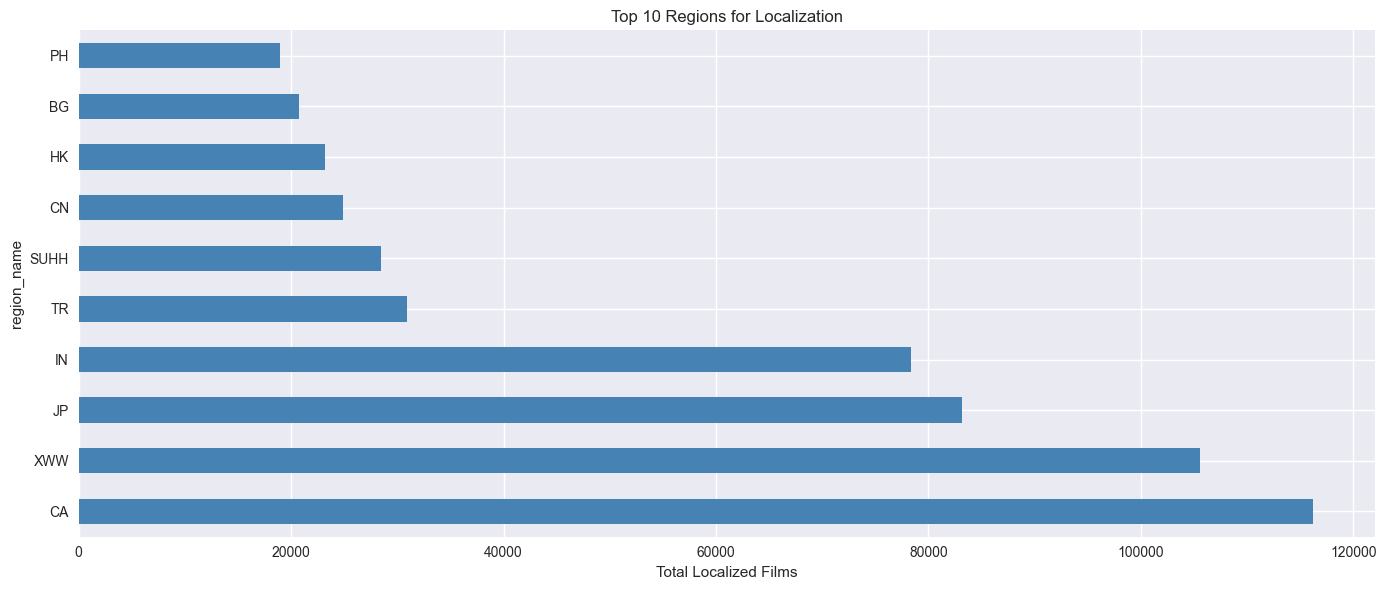

In [6]:
query1 = """
SELECT 
    r.region_code AS region_name,  -- Using region_code as the name
    l.language_code AS language_name,  -- Using language_code as the name
    COUNT(*) AS localized_count
FROM dwh.fact_film_version f  
JOIN dwh.dim_region r ON f.region_id = r.region_id  
JOIN dwh.dim_language l ON f.language_id = l.language_id  
WHERE f.is_original_title = FALSE  -- TRUE/FALSE are standard SQL Booleans
  AND r.region_code != 'UNK'  -- Using the code 'UNK' for unknown
  AND l.language_code != 'UNK'  -- Using the code 'UNK' for unknown
GROUP BY r.region_code, l.language_code
ORDER BY localized_count DESC
LIMIT 20;
"""

df1 = pd.read_sql(query1, engine)

#top 10 regions by total localized films
top_regions = df1.groupby('region_name')['localized_count'].sum().nlargest(10)

fig, ax = plt.subplots(1, figsize=(14, 6))

#top regions
top_regions.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 10 Regions for Localization')
ax.set_xlabel('Total Localized Films')

plt.tight_layout()
plt.show()

## 2. Do films that are localized into multiple regions or languages tend to receive more votes (i.e., greater visibility) than non-localized films?

We compare the average number of votes for films that are not localized vs. those localized into 1, 2, or many regions. We use `num_votes` as a proxy for global visibility and popularity.

C:\Users\Vaughn Sy\AppData\Local\Temp\ipykernel_19248\388587107.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='localization_level', y='avg_votes', ax=ax, palette="viridis")


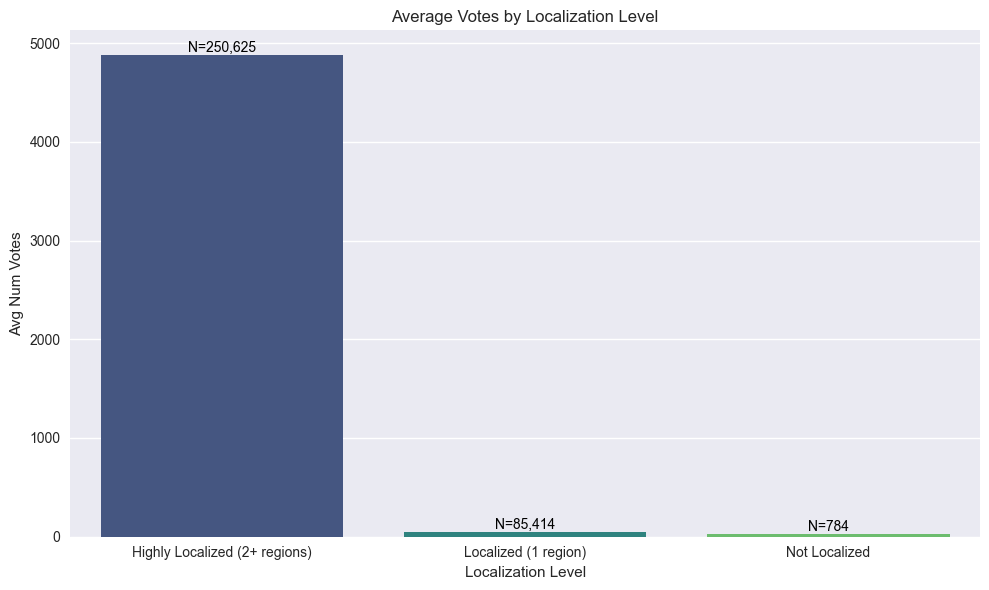

In [ ]:
query2 = """
WITH film_localization AS (
    SELECT 
        dt.tconst,
        dt.average_rating, 
        dt.num_votes,      
        COUNT(f.version_id) AS total_versions,
        SUM(CASE WHEN f.is_original_title = FALSE THEN 1 ELSE 0 END) AS localized_count
    FROM dwh.fact_film_version f 
    JOIN dwh.dim_title dt ON f.title_id = dt.title_id 
    GROUP BY dt.tconst, dt.average_rating, dt.num_votes
),
categorized_films AS (
    SELECT 
        CASE 
            WHEN localized_count = 0 THEN 'Not Localized'
            WHEN localized_count = 1 THEN 'Localized (1 region)'
            ELSE 'Highly Localized (2+ regions)'
        END AS localization_level,
        num_votes
    FROM film_localization
    WHERE num_votes IS NOT NULL AND num_votes > 0
)
SELECT 
    localization_level,
    AVG(num_votes) AS avg_votes,
    COUNT(*) AS film_count
FROM categorized_films
GROUP BY localization_level
ORDER BY avg_votes DESC;
"""

df2 = pd.read_sql(query2, engine)

fig, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(data=df2, x='localization_level', y='avg_votes', ax=ax, palette="viridis")
ax.set_title('Average Votes by Localization Level')
ax.set_ylabel('Avg Num Votes')
ax.set_xlabel('Localization Level')

for index, row in df2.iterrows():
    ax.text(index, row['avg_votes'], f"N={row['film_count']:,}", 
            color='black', ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

## 3. What genres are most commonly adapted for international audiences, and how does this vary by target region or language?

We examine which genres are most frequently adapted for non-original versions, and how this varies by target region. This reveals cultural preferences in content distribution.

In [ ]:
query3 = """
SELECT 
    r.region_name,
    g.genre_name,
    COUNT(*) AS adaptation_count
FROM fact_film_version f
JOIN fact_genre_bridge b ON f.fact_id = b.fact_id
JOIN dim_genre g ON b.genre_id = g.genre_id
JOIN dim_region r ON f.region_id = r.region_id
WHERE f.is_original_title = false
  AND r.region_name IN ('US', 'JP', 'FR', 'BR', 'DE')  -- Focus on key markets
  AND r.region_id != -1
GROUP BY r.region_name, g.genre_name
ORDER BY r.region_name, adaptation_count DESC;
"""

df3 = pd.read_sql(query3, engine)

pivot = df3.pivot(index='region_name', columns='genre_name', values='adaptation_count').fillna(0)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5, ax=ax)
ax.set_title('Genre Adaptation by Region (Top 5 Markets)')
ax.set_xlabel('Genre')
ax.set_ylabel('Region')
plt.show()

## 4. How have localization patterns (e.g., number of non-original titles per year) and genre preferences in localized films evolved over time?

We track how the number of localized films has changed over decades, broken down by genre. This shows how globalization strategies have shifted since the 1980s.

In [ ]:
query4 = """
SELECT 
    t.decade,
    g.genre_name,
    COUNT(*) AS localized_films
FROM fact_film_version f
JOIN fact_genre_bridge b ON f.fact_id = b.fact_id
JOIN dim_genre g ON b.genre_id = g.genre_id
JOIN dim_time t ON f.time_id = t.time_id
WHERE f.is_original_title = false
  AND t.decade >= 1980
  AND g.genre_name IN ('Drama', 'Comedy', 'Action', 'Animation', 'Sci-Fi')  -- Major genres
GROUP BY t.decade, g.genre_name
ORDER BY t.decade, localized_films DESC;
"""

df4 = pd.read_sql(query4, engine)

plt.figure(figsize=(12, 6))
for genre in df4['genre_name'].unique():
    subset = df4[df4['genre_name'] == genre]
    plt.plot(subset['decade'], subset['localized_films'], label=genre, marker='o')

plt.title('Localization Trends by Genre (1980–2020s)')
plt.xlabel('Decade')
plt.ylabel('Number of Localized Films')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()